

# Tổng quan

Hướng dẫn này dựa trên hướng dẫn [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from dataloader import image_dataset_from_directory

## Tiền xử lý dữ liệu

### Tải dữ liệu

In [69]:
! wget https://raw.githubusercontent.com/hcmcaic/ai4vn-hackathon-2020/main/sample_data.zip
! unzip sample_data.zip

path_to_data = PATH

train_dir = os.path.join(path_to_data, 'train')
validation_dir = os.path.join(path_to_data, 'val')

BATCH_SIZE = 10
IMG_SIZE = (160, 160)

NUM_CLASS = 9

train_dataset, train_dataset_filenames = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

--2020-11-18 10:00:51--  https://raw.githubusercontent.com/hcmcaic/ai4vn-hackathon-2020/main/sample_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40856065 (39M) [application/zip]
Saving to: ‘sample_data.zip’

sample_data.zip     100%[===================>]  38.96M   109MB/s    in 0.4s    

2020-11-18 10:00:52 (109 MB/s) - ‘sample_data.zip’ saved [40856065/40856065]

Archive:  sample_data.zip
replace sample_data/train/cay_nga/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_data/train/cay_nga/000001.jpg  
 extracting: sample_data/train/cay_nga/000002.jpg  
  inflating: sample_data/train/cay_nga/000003.jpg  
  inflating: sample_data/train/cay_nga/000004.jpg  
  inflating: sample_data/train/cay_nga/000005.jpg  
  inflating: sample_da

In [70]:
validation_dataset, validation_dataset_filenames = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 22 files belonging to 9 classes.


Hiển thị 9 hình ảnh và nhãn đầu tiên từ bộ huấn luyện:

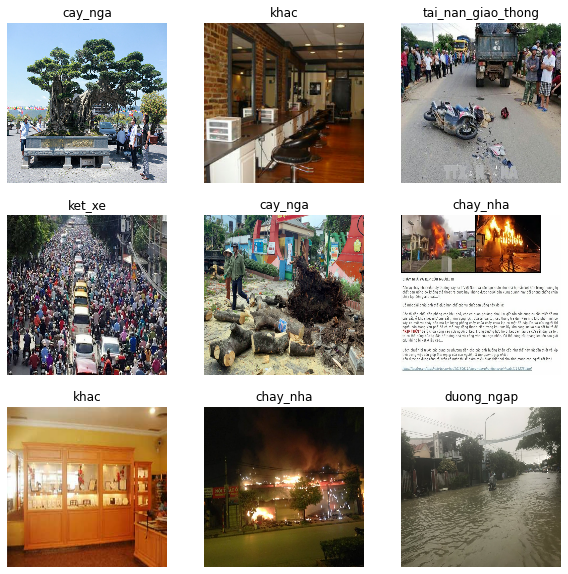

In [71]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Định cấu hình cho tập dữ liệu

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [72]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)



### Sử dụng tăng cường dữ liệu

Khi dữ liệu ảnh không đủ lớn, bạn có thể tăng tính đa dạng của các mẫu dữ liệu bằng cách áp các phép biến đổi ngẫu nhiên. Điều này giúp giảm [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). Bạn có thể tìm hiểu thêm về tăng dữ liệu trong [hướng dẫn](https://www.tensorflow.org/tutorials/images/data_augmentation) này.

In [73]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Dưới đây là kết quả của việc tăng cường dữ liệu trên một tấm ảnh.

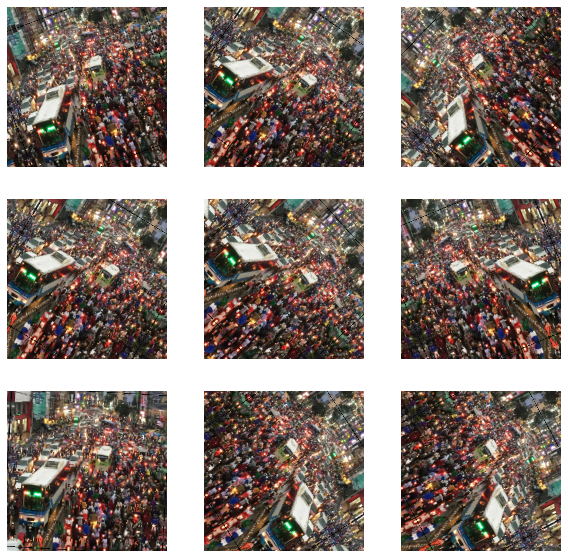

In [74]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values
Trong ví dụ này, ta sử dụng mô hình cơ sở tf.keras.applications.MobileNetV2. Mô hình này sử dụng giá trị điểm ảnh trong đoạn `[-1,1]` nhưng giá trị ảnh hiện tại đang trong đoạn `[0-255]`. Vì thế ta cần chuẩn hóa lại miền giá trị điểm ảnh.

In [75]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [76]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


## Create the base model from the pre-trained convnets


In [77]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


Mô hình trích xuất đặc trưng này nhận tấm ảnh với kích thước `160x160x3` chuyển thành đặc trưng `5x5x1280`

In [78]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 5, 5, 1280)


## Feature extraction

### Freeze the convolutional base

In [79]:
base_model.trainable = False

In [80]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

In [81]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 1280)


In [82]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASS)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 9)


In [83]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model


In [84]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [86]:
len(model.trainable_variables)

2

### Train the model


In [87]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 0s 7ms/step - loss: 2.8539 - accuracy: 0.0909


In [88]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.85
initial accuracy: 0.09


In [89]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
18/18 [==============================] - 1s 49ms/step - loss: 2.8806 - accuracy: 0.1461 - val_loss: 2.6369 - val_accuracy: 0.1364
Epoch 2/10
18/18 [==============================] - 1s 48ms/step - loss: 2.6685 - accuracy: 0.1348 - val_loss: 2.4881 - val_accuracy: 0.0909
Epoch 3/10
18/18 [==============================] - 1s 48ms/step - loss: 2.5780 - accuracy: 0.1124 - val_loss: 2.3672 - val_accuracy: 0.1364
Epoch 4/10
18/18 [==============================] - 1s 50ms/step - loss: 2.3508 - accuracy: 0.2247 - val_loss: 2.2668 - val_accuracy: 0.1818
Epoch 5/10
18/18 [==============================] - 1s 51ms/step - loss: 2.1962 - accuracy: 0.2416 - val_loss: 2.1702 - val_accuracy: 0.1818
Epoch 6/10
18/18 [==============================] - 1s 52ms/step - loss: 2.1627 - accuracy: 0.2416 - val_loss: 2.0884 - val_accuracy: 0.1818
Epoch 7/10
18/18 [==============================] - 1s 50ms/step - loss: 1.8834 - accuracy: 0.3202 - val_loss: 1.9973 - val_accuracy: 0.2273
Epoch 8/10
18

### Learning curves


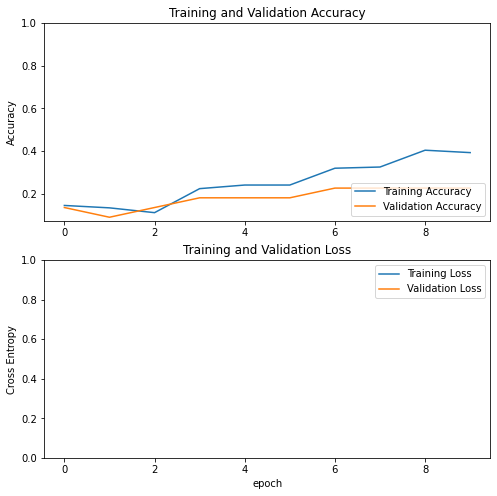

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


In [91]:
base_model.trainable = True

In [92]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model



In [93]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [94]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [95]:
len(model.trainable_variables)

58

### Continue training the model

In [96]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
18/18 [==============================] - 2s 90ms/step - loss: 1.5851 - accuracy: 0.4326 - val_loss: 1.4933 - val_accuracy: 0.4091
Epoch 11/20
18/18 [==============================] - 1s 51ms/step - loss: 1.1972 - accuracy: 0.5843 - val_loss: 1.3158 - val_accuracy: 0.5909
Epoch 12/20
18/18 [==============================] - 1s 52ms/step - loss: 1.0053 - accuracy: 0.6292 - val_loss: 1.2024 - val_accuracy: 0.6818
Epoch 13/20
18/18 [==============================] - 1s 52ms/step - loss: 0.8470 - accuracy: 0.7360 - val_loss: 1.0831 - val_accuracy: 0.6818
Epoch 14/20
18/18 [==============================] - 1s 55ms/step - loss: 0.7932 - accuracy: 0.7472 - val_loss: 1.0371 - val_accuracy: 0.6818
Epoch 15/20
18/18 [==============================] - 1s 52ms/step - loss: 0.7285 - accuracy: 0.7416 - val_loss: 0.9396 - val_accuracy: 0.7273
Epoch 16/20
18/18 [==============================] - 1s 52ms/step - loss: 0.6294 - accuracy: 0.7809 - val_loss: 0.8964 - val_accuracy: 0.6818
Epoch 

In [97]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

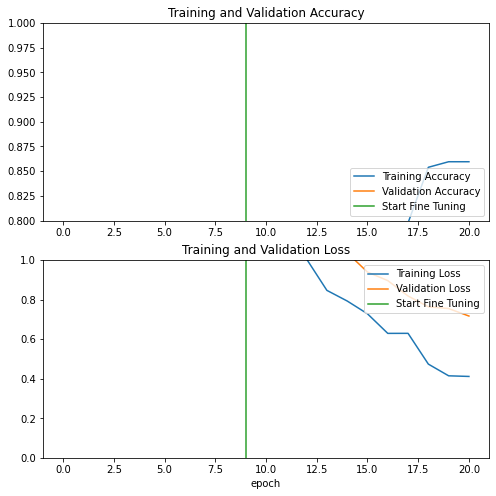

In [98]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [99]:
loss, accuracy = model.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)

3/3 [==============================] - 0s 7ms/step - loss: 0.7172 - accuracy: 0.7273
Validation accuracy : 0.7272727489471436


Predictions:
 [3 2 7 4 6 2 0 0 2 8]
Labels:
 [3 2 7 4 6 6 4 0 2 5]


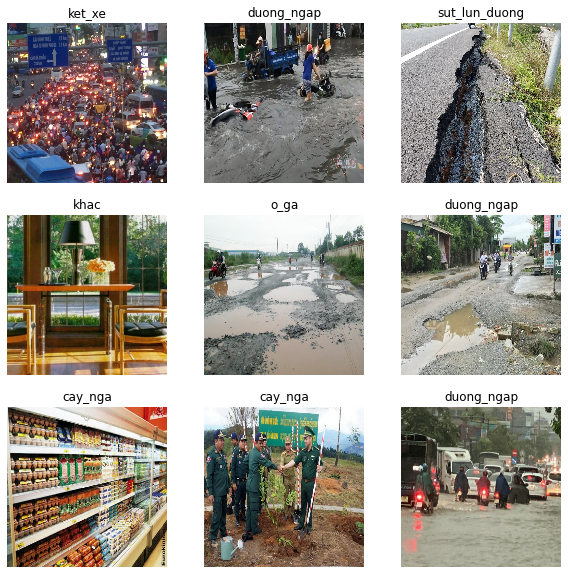

In [100]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predicted_class = np.argmax(predictions, axis=-1)


print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predicted_class[i]])
  plt.axis("off")

In [101]:
predictions = model.predict(validation_dataset)

predicted_class = np.argmax(predictions, axis=-1)


print('Predictions:\n', predicted_class)

Predictions:
 [4 2 0 2 3 4 2 3 0 0 4 4 7 7 6 8 6 1 8 6 4 8]


In [109]:
for filename, predicted in zip(validation_dataset_filenames, predicted_class):
  print(filename, class_names[predicted])

/root/.keras/datasets/sample_data/val/chay_nha/000019.jpg khac
/root/.keras/datasets/sample_data/val/khac/40.jpg duong_ngap
/root/.keras/datasets/sample_data/val/nut_vo_duong/000020.jpg cay_nga
/root/.keras/datasets/sample_data/val/duong_ngap/000020.jpg duong_ngap
/root/.keras/datasets/sample_data/val/o_ga/000019.jpg ket_xe
/root/.keras/datasets/sample_data/val/khac/38.jpg khac
/root/.keras/datasets/sample_data/val/tai_nan_giao_thong/000019.jpg duong_ngap
/root/.keras/datasets/sample_data/val/ket_xe/000020.jpg ket_xe
/root/.keras/datasets/sample_data/val/tai_nan_giao_thong/000020.jpg cay_nga
/root/.keras/datasets/sample_data/val/nut_vo_duong/000019.jpg cay_nga
/root/.keras/datasets/sample_data/val/sut_lun_duong/000020.jpg khac
/root/.keras/datasets/sample_data/val/khac/35.jpg khac
/root/.keras/datasets/sample_data/val/cay_nga/000019.jpg sut_lun_duong
/root/.keras/datasets/sample_data/val/khac/39.jpg sut_lun_duong
/root/.keras/datasets/sample_data/val/khac/37.jpg o_ga
/root/.keras/datas